# 1. Introduction Fruit classification project

Use Deep Learning to predict kind of fruit as the given image. This project should follow the guideline as:

1. Perform data exploration (group images, do clustering
analysis for images, display images for analysis, etc.).
2. Use CNN with classification_report to do prediction.
3. Use RNN with classification_report to do prediction.
4. Tune the models if necessary.
5. Use separate test set images to verify model accuracy.
6. Write up analysis to compare CNN vs. RNN.Fruit classification project



# 1. Load data from kaggle

In [0]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"danghung","key":"d4c1641822cd147aaee317b392c9d4c3"}'}

In [0]:
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json

-rw-r--r-- 1 root root 64 Dec  9 08:35 kaggle.json


In [0]:
# Next, install the Kaggle API client.
!pip install -q kaggle

In [0]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
!kaggle -v
!pwd

Kaggle API 1.5.4
/content


In [0]:
!kaggle datasets list -s fruits

ref                                                         title                                               size  lastUpdated          downloadCount  
----------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  
moltean/fruits                                              Fruits 360                                         734MB  2019-11-04 21:16:32          31404  
sriramr/fruits-fresh-and-rotten-for-classification          Fruits fresh and rotten for classification           4GB  2018-08-24 15:05:40           1252  
mjamilmoughal/fruits-with-colors-dataset                    Fruits with colors dataset                          816B  2018-01-13 10:22:33           2625  
mbkinaci/fruit-images-for-object-detection                  Fruit Images for Object Detection                   28MB  2018-07-01 20:21:59           3853  
raghu07/vegetable-and-fruits-price-in-india                 Daily Vege

In [0]:
# Copy the stackoverflow data set locally.
!kaggle datasets download -d moltean/fruits

 99% 727M/734M [00:06<00:00, 80.1MB/s]
100% 734M/734M [00:06<00:00, 121MB/s] 


In [0]:
!rm kaggle.json
!ls -la

total 752116
drwxr-xr-x 1 root root      4096 Dec  9 08:36  .
drwxr-xr-x 1 root root      4096 Dec  9 08:25  ..
drwxr-xr-x 1 root root      4096 Dec  5 16:38  .config
drwxr-xr-x 3 root root      4096 Dec  9 08:36  fruits-360_dataset
-rw-r--r-- 1 root root 770126979 Dec  9 08:36  fruits.zip
-rw-r--r-- 1 root root        64 Dec  9 08:31 'kaggle (1) (1).json'
-rw-r--r-- 1 root root        64 Dec  9 08:30 'kaggle (1).json'
-rw-r--r-- 1 root root        64 Dec  9 08:33 'kaggle (2).json'
drwxr-xr-x 1 root root      4096 Nov 27 22:38  sample_data


In [0]:
import os
from os import listdir, makedirs
from os.path import join, exists, expanduser

from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
# from keras import backend as K

# 2. Data exploring

In [0]:
# dimensions of our images.
img_width, img_height = 100, 100 

train_data_dir = '/content/fruits-360_dataset/fruits-360/Training/'
test_data_dir = '/content/fruits-360_dataset/fruits-360/Test/'
nb_train_samples = 31688
nb_validation_samples = 10657
batch_size = 300

In [0]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)


Found 60498 images belonging to 120 classes.
Found 20622 images belonging to 120 classes.


In [0]:
import pandas as pd
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

In [0]:
training_data = pd.DataFrame(train_generator.classes, columns=['classes'])

# def create_stack_bar_data(col, df):
#     aggregated = df[col].value_counts().sort_index()
#     x_values = aggregated.index.tolist()
#     y_values = aggregated.values.tolist()
#     return x_values, y_values

class_names_training_data = list(train_generator.class_indices.keys())
testing_data = pd.DataFrame(test_generator.classes, columns=['classes'])
class_names_testing_data = list(test_generator.class_indices.keys())

print(class_names_training_data)


['Apple Braeburn', 'Apple Crimson Snow', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith', 'Apple Pink Lady', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apricot', 'Avocado', 'Avocado ripe', 'Banana', 'Banana Lady Finger', 'Banana Red', 'Beetroot', 'Blueberry', 'Cactus fruit', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula', 'Cauliflower', 'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black', 'Cherry Wax Red', 'Cherry Wax Yellow', 'Chestnut', 'Clementine', 'Cocos', 'Dates', 'Eggplant', 'Ginger Root', 'Granadilla', 'Grape Blue', 'Grape Pink', 'Grape White', 'Grape White 2', 'Grape White 3', 'Grape White 4', 'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Hazelnut', 'Huckleberry', 'Kaki', 'Kiwi', 'Kohlrabi', 'Kumquats', 'Lemon', 'Lemon Meyer', 'Limes', 'Lychee', 'Mandarine', 'Mango', 'Mango Red', 'Mangostan', 'Maracuja', 'Melon Piel de Sapo', 'Mulberry', 'Nectarine', 'Nectarine Flat', 'Nut

In [0]:
training_data = pd.DataFrame(train_generator.classes, columns=['classes'])
testing_data = pd.DataFrame(test_generator.classes, columns=['classes'])

training_data['name'] = training_data['classes'].apply(lambda x: class_names_training_data[x])
testing_data['name'] = testing_data['classes'].apply(lambda x: class_names_testing_data[x])

In [0]:

training_data.head()

,classes,name
0,0,Apple Braeburn
1,0,Apple Braeburn
2,0,Apple Braeburn
3,0,Apple Braeburn
4,0,Apple Braeburn


In [0]:
training_data['name'].value_counts()

Grape Blue            984
Plum 3                900
Peach 2               738
Melon Piel de Sapo    738
Strawberry Wedge      738
                     ... 
Pear Kaiser           300
Mangostan             300
Nut Forest            218
Nut Pecan             178
Ginger Root            99
Name: name, Length: 120, dtype: int64

In [0]:
testing_data['name'].value_counts()

Grape Blue            328
Plum 3                304
Walnut                249
Peach 2               246
Melon Piel de Sapo    246
                     ... 
Plum 2                142
Tomato Maroon         127
Mangostan             102
Pear Kaiser           102
Ginger Root            99
Name: name, Length: 120, dtype: int64

# 3. Model

In [0]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4311069630080101740
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 9483414099042082189
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 14231498688984827924
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15956161332
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5407983049169512891
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


# CNN Model 
- conv1 16
- maxpool1
- conv2 32
- maxpool2
- conv3 64
- maxpool3
- conv4 128
- maxpool4
- Flatten
- Reshape
- fc1 128
- dropout
- fc2 1024
- dropout
- Softmax 256



In [0]:
from keras.layers import GlobalAveragePooling2D, Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, Input
import keras

In [0]:
model = Sequential()
# Add a convolutional layer with 32 filters of size 3x3
model.add(Conv2D(filters=16, kernel_size=5,
        input_shape=(100, 100, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(filters=32, kernel_size=5,
        input_shape=(100, 100, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(filters=64, kernel_size=5,
        input_shape=(100, 100, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Conv2D(filters=128, kernel_size=5,
        input_shape=(100, 100, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(120, activation='softmax'))

print(model.summary())







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 16)        1216      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 32)        12832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 18, 64)        51264     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 9, 9, 64)          0         


# Model visualization

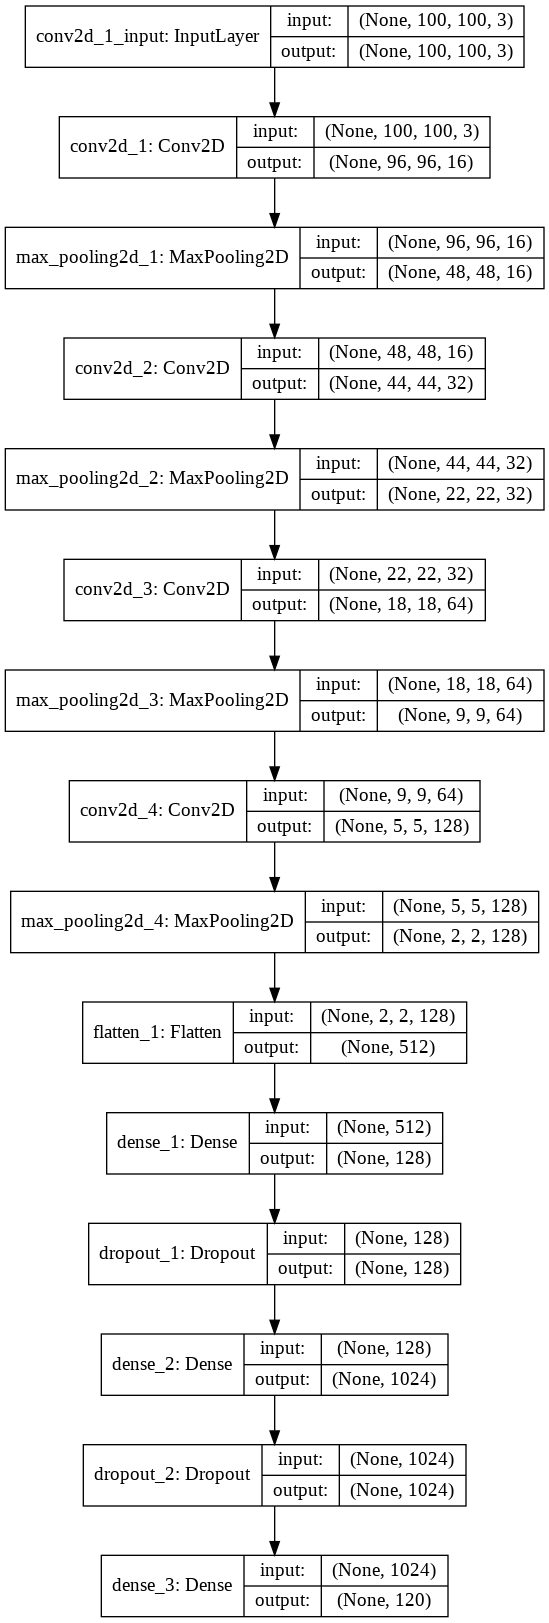

In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [0]:
import tensorflow as tf
num_of_train_samples = 60498
num_of_test_samples = 20622
model.compile(loss=keras.losses.categorical_crossentropy, 
        optimizer=keras.optimizers.Adadelta(), 
        metrics=['accuracy'])
with tf.device("/device:GPU:0"):
  history = model.fit_generator(train_generator, epochs=10,
          steps_per_epoch= num_of_train_samples // batch_size,
          verbose = 1, 
          validation_data = test_generator,
          validation_steps=num_of_test_samples // batch_size)

print(history.history.keys())

Epoch 1/10
201/201 [==============================] - 158s 785ms/step - loss: 0.5563 - acc: 0.8158 - val_loss: 0.4355 - val_acc: 0.8685
Epoch 2/10
201/201 [==============================] - 157s 783ms/step - loss: 0.3189 - acc: 0.8943 - val_loss: 1.0270 - val_acc: 0.7572
Epoch 3/10
201/201 [==============================] - 158s 787ms/step - loss: 0.2448 - acc: 0.9220 - val_loss: 0.2262 - val_acc: 0.9477
Epoch 4/10
201/201 [==============================] - 155s 774ms/step - loss: 0.1725 - acc: 0.9444 - val_loss: 0.2008 - val_acc: 0.9490
Epoch 5/10
201/201 [==============================] - 158s 788ms/step - loss: 0.1433 - acc: 0.9550 - val_loss: 0.2842 - val_acc: 0.9292
Epoch 6/10
201/201 [==============================] - 157s 783ms/step - loss: 0.1466 - acc: 0.9551 - val_loss: 0.1759 - val_acc: 0.9578
Epoch 7/10
201/201 [==============================] - 157s 779ms/step - loss: 0.1026 - acc: 0.9670 - val_loss: 0.1714 - val_acc: 0.9609
Epoch 8/10
201/201 [============================

Apple Pink Lady
6


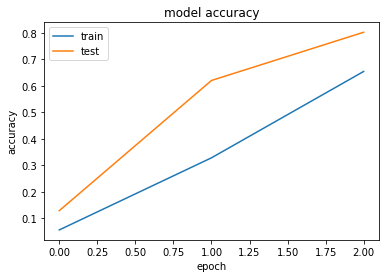

In [0]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

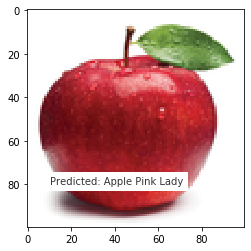

In [104]:
import numpy as np
from PIL import Image
test_image = 'apple_test.jpg'
load_img = Image.open(test_image).resize((100, 100), Image.ANTIALIAS)
img = np.expand_dims(load_img, axis=0)
result= model.predict(img)
y_predict_classes = np.argmax(result) 
y_predict_classes = class_names_training_data[y_predict_classes]

f, ax = plt.subplots(1, 1)
for i in range(1):
    ax.imshow(Image.open(test_image).resize((100, 100), Image.ANTIALIAS))
    ax.text(10, 80, 'Predicted: %s' % y_predict_classes, color='k', backgroundcolor='white', alpha=0.8)
plt.show()

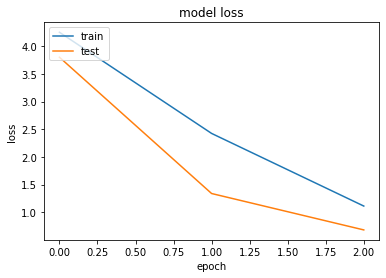

In [0]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
from sklearn import metrics
import numpy as np

# Predict test data
y_predict = model.predict_generator(test_generator, num_of_test_samples // batch_size+1)
y_predict_classes = np.argmax(y_predict, axis=1) 
print(y_predict_classes)


[  0   0   0 ... 119 119 119]


In [0]:
# Real data
y_true = test_generator.classes
print(y_true)
print(y_predict_classes)

# print report
print(metrics.classification_report(y_true, y_predict_classes, target_names=class_names_training_data))

[  0   0   0 ... 119 119 119]
[  0   0   0 ... 119 119 119]
                     precision    recall  f1-score   support

     Apple Braeburn       0.58      0.51      0.55       164
 Apple Crimson Snow       0.70      0.33      0.45       148
     Apple Golden 1       0.29      0.68      0.41       164
     Apple Golden 2       0.75      0.07      0.13       164
     Apple Golden 3       0.50      0.58      0.54       161
 Apple Granny Smith       0.74      0.63      0.68       164
    Apple Pink Lady       0.65      0.48      0.55       152
        Apple Red 1       0.82      0.53      0.64       164
        Apple Red 2       0.65      0.98      0.79       164
        Apple Red 3       0.86      0.92      0.89       144
Apple Red Delicious       0.87      0.77      0.81       166
 Apple Red Yellow 1       1.00      0.57      0.73       164
 Apple Red Yellow 2       0.88      0.92      0.90       219
            Apricot       0.73      1.00      0.85       164
            Avocado     

# Load model from file

In [106]:
from keras.models import model_from_json
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/fruits_cnn_weight.h5")
print("Loaded model from disk")

Loaded model from disk


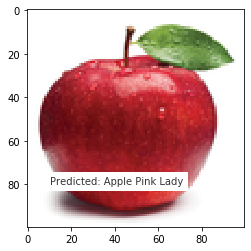

In [119]:
import numpy as np
from PIL import Image
test_image = 'apple_test.jpg'
load_img = Image.open(test_image).resize((100, 100), Image.ANTIALIAS)
img = np.expand_dims(load_img, axis=0)
result= loaded_model.predict(img)
y_predict_classes = np.argmax(result) 
y_predict_classes = class_names_training_data[y_predict_classes]

f, ax = plt.subplots(1, 1)
for i in range(1):
    ax.imshow(Image.open(test_image).resize((100, 100), Image.ANTIALIAS))
    ax.text(10, 80, 'Predicted: %s' % y_predict_classes, color='k', backgroundcolor='white', alpha=0.8)
plt.show()

In [118]:
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize

class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
# Create model object in inference mode.
model_rcnn = modellib.MaskRCNN(mode="inference", model_dir='/content/mode_dir', config=config)

# Load weights trained on MS-COCO
model_rcnn.load_weights('/content/mask_rcnn_balloon.h5', by_name=True)

AttributeError: ignored

In [111]:



# Load a random image from the images folder
image = Image.open(test_image)

# Run detection
results = model_rcnn.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

NameError: ignored

In [108]:
!pip install mrcnn

     |████████████████████████████████| 61kB 2.9MB/s 
  Created wheel for mrcnn: filename=mrcnn-0.2-cp36-none-any.whl size=54932 sha256=90b21ebf320de09f9fe2aff9752e37420e7fb2892a308208c7c527924edb8995
  Stored in directory: /root/.cache/pip/wheels/11/ed/28/e550ddc897c04c336b923eae4eb35c9aae993d20ce39d9cc40
Successfully built mrcnn


# Conclustion

In [0]:
Above CNN architecture give us 96% accuracy.

SyntaxError: ignored